In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
def grib_to_dataframe(date, base_path):
    directory = f"{base_path}/{date.replace(':', '-')}"
    file_list = [os.path.join(directory, file.replace(':', '-')) for file in os.listdir(directory)]

    backend_kwargs = [
        {'filter_by_keys': {'paramId': 167, 'level': 2}},
        {'filter_by_keys': {'paramId': 228228}}
    ]

    datasets = []
    for file in file_list:
        for bk in backend_kwargs:
            ds = xr.open_dataset(file, engine='cfgrib', backend_kwargs=bk)
            datasets.append(ds)

    ds = xr.merge(datasets)
    return ds.to_dataframe().reset_index()

In [30]:
def arome_mean_departement(dep_df, mean_arome_df):
    lst = []
    for i in dep_coords['Dep'].unique():
        dep_coords_dep = dep_df[dep_df['Dep'] == i]
        dsf_dep = pd.merge(mean_arome_df, dep_coords_dep, on=['latitude', 'longitude'], how='inner')
        mean_temp_dep = dsf_dep['t2m'].mean() - 273.15
        mean_precip_dep = dsf_dep['tp'].mean()
        data = [i, mean_temp_dep, mean_precip_dep]
        lst.append(data)
    df = pd.DataFrame(lst, columns=['DEPARTEMENT', 'TmpMean', 'PrecipMean'])
    
    corsica = df[(df['DEPARTEMENT'] == '2A') | (df['DEPARTEMENT'] == '2B')][['TmpMean', 'PrecipMean']].mean()
    corsica_df = pd.DataFrame({
        'DEPARTEMENT': ['20'],
        'TmpMean': [corsica['TmpMean']],
        'PrecipMean': [corsica['PrecipMean']]
    })
    df_mean_arome = pd.concat([df, corsica_df]).reset_index(drop=True)
    df_mean_arome = df_mean_arome[~df_mean_arome['DEPARTEMENT'].isin(['2A', '2B'])]
    df_mean_arome.loc[:, 'DEPARTEMENT'] = df_mean_arome['DEPARTEMENT'].astype('int8')
    
    return df_mean_arome

In [4]:
def get_surf_rend_prod_data(year):
    df = pd.read_csv('C:/Users/alexl/Documents/GitHub/agriApp/static/files/SCR-GRC-hist_dep_surface_prod_cult_cer-A24.csv', 
                     encoding='ISO-8859-1', delimiter=';', decimal=',', usecols=['DEP', 'ESPECES', 'ANNEE', 'CULT_SURF', 'CULT_REND', 'CULT_PROD'], 
                     dtype={'ANNEE': 'int32', 'CULT_SURF': 'float32', 'CULT_REND': 'float32', 'CULT_PROD': 'float32'})
    df = df.rename(columns={'DEP': 'DEPARTEMENT'})
    df['DEPARTEMENT'] = df['DEPARTEMENT'].str.strip()
    df['ESPECES'] = df['ESPECES'].str.rstrip()
    df = df[(df['ESPECES'] == 'Blé tendre') | (df['ESPECES'] == 'Maïs (grain et semence)') | (df['ESPECES'] == 'Colza')]
    df = df[df['ANNEE'] == year].reset_index(drop=True)
    #Corsica
    corsica = df[(df['DEPARTEMENT'] == '2A') | (df['DEPARTEMENT'] == '2B')]
    corsica_group = corsica.groupby('ESPECES')[['CULT_SURF']].mean().reset_index()
    corsica_group['ANNEE'] = year
    corsica_group['DEPARTEMENT'] = '20'
    df_mean_corsica = pd.concat([df, corsica_group]).reset_index(drop=True)
    df_mean_corsica = df_mean_corsica[~df_mean_corsica['DEPARTEMENT'].isin(['2A', '2B'])]
    df_mean_corsica.loc[:, 'DEPARTEMENT'] = df_mean_corsica['DEPARTEMENT'].astype('int8')

    return df_mean_corsica[['ESPECES', 'DEPARTEMENT', 'CULT_SURF']]

In [5]:
def dask_historical_data(csv_path):
    df = dd.read_csv(csv_path, usecols=['NUM_POSTE', 'DEPARTEMENT', 'ALTI', 'AAAAMMJJ', 'RR', 'TM'], dtype={'DEPARTEMENT':'int8','ALTI':'int32', 'RR':'float32', 'TM': 'float32'}, parse_dates=['AAAAMMJJ'])
    same_day_mask = (df['AAAAMMJJ'].dt.month == datetime.today().month) & (df['AAAAMMJJ'].dt.day == datetime.today().day)
    next_day_mask = (df['AAAAMMJJ'].dt.month == (datetime.today() + timedelta(days=1)).month) & (df['AAAAMMJJ'].dt.day == (datetime.today() + timedelta(days=1)).day)
    combined_mask = same_day_mask | next_day_mask
    df_today_historical_plus_48h = df[combined_mask]
    df_today_historical_plus_48h['Year'] = df_today_historical_plus_48h['AAAAMMJJ'].dt.year
    df_today_historical_plus_48h = df_today_historical_plus_48h.compute()
    RRdata = df_today_historical_plus_48h.groupby(['DEPARTEMENT', 'Year', 'NUM_POSTE'])['RR'].sum(numeric_only=True).reset_index() #group the two days together and sum them
    RRdata = RRdata.groupby('DEPARTEMENT')['RR'].mean(numeric_only=True) #take the grouped sum of the two days for each stations and mean them
    TMdata = df_today_historical_plus_48h.groupby('DEPARTEMENT')['TM'].mean(numeric_only=True)
    mean_historical = pd.merge(RRdata, TMdata, left_index=True, right_index=True)
    return mean_historical.reset_index()

In [6]:
def temp_precip_weighted(df):
    weighted = {}
    for cult in weighted_df.columns[weighted_df.columns.str.startswith('CULT_SURF')]:
        temp_sum = sum(t * s for t, s in zip(final_df['TmpAnomaly'], weighted_df[cult]))
        temp_weighted = temp_sum / weighted_df[cult].sum()
        precip_sum = sum(t * s for t, s in zip(final_df['PrecipAnomaly%'], weighted_df[cult]))
        precip_weighted = precip_sum / weighted_df[cult].sum()
        weighted[cult.replace("CULT_SURF ", "")] = [round(temp_weighted,2), round(precip_weighted,2)]
    return weighted

In [7]:
def create_map(df):
    #Colors for the persolised colormap
    tempcmp = np.array([[10/256, 0, 110/256, 1], [0,0,180/256,1], [0, 0, 255/256, 1], [28/256, 134/256, 238/256, 1], [0, 230/256, 240/256, 1], 
                        [156/256, 255/256, 255/256, 1], [255/256, 255/256, 156/256, 1], [255/256, 254/256, 0, 1], [255/256, 200/256, 0, 1], 
                        [255/256, 100/256, 0, 1], [255/256, 0, 0, 1], [180/256, 0, 0, 1]])
    precipcmp = np.array([[130/256,42/256,4/256,1], [204/256,76/256,2/256,1], [236/256,113/256,20/256,1], [254/256,161/256,41/256,1], [254/256,215/256,79/256,1], 
                        [254/256, 245/256, 145/256,1], [204/256, 237/256, 230/256,1], [153/256, 216/256, 201/256,1], [102/256, 195/256, 164/256,1], 
                        [65/256, 175/256, 118/256,1], [35/256, 139/256, 69/256, 1], [0, 89/256, 3/256,1]])
    tempcmp = ListedColormap(tempcmp)
    precipcmp = ListedColormap(precipcmp)

    fig, axes = plt.subplots(1, 2, figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    # Define the extent of the map to be France centered
    extent = [-5, 10, 41, 52]

    #Boundaries for the cmap
    tempBoundaries = [-15, -10, -8, -4, -2, -1, 0, 1, 2, 4, 6, 10, 15]
    min_precip = min(round(df['PrecipAnomaly%'].min(), 0), 0) #min anomaly or 0
    max_precip = max(round(df['PrecipAnomaly%'].max(), 0), 300) #max anomaly or 300
    precipBoundaries = [min_precip, 10, 20, 40, 60, 80, 100, 120, 150, 200, 250, 300, max_precip]
    precipBoundaries = sorted(list(set(precipBoundaries))) #sort and remove duplicates

    # Colormap normalisation
    normTemp = BoundaryNorm(tempBoundaries, tempcmp.N)
    normPrecip = BoundaryNorm(precipBoundaries, precipcmp.N)

    # Loop through each axis and apply the settings
    for ax in axes:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        
    df.plot(column='TmpAnomaly', ax=axes[0], cmap=tempcmp, norm=normTemp, edgecolor='black', linewidth=0.5)
    df.plot(column='PrecipAnomaly%', ax=axes[1], cmap=precipcmp, norm=normPrecip, edgecolor='black', linewidth=0.5)

    # Set titles
    axes[0].set_title('Temp 2m(°C) Anomaly')
    axes[1].set_title('Cumul. Precip.(%) Anomaly')

    #Colormap and colorbar properties
    smTemp = plt.cm.ScalarMappable(cmap=tempcmp, norm=normTemp)
    smTemp.set_array([])
    smPrecip = plt.cm.ScalarMappable(cmap=precipcmp, norm=normPrecip)
    smPrecip.set_array([])
    cbarTemp = plt.colorbar(smTemp, ax=axes[0], location='bottom', pad=0.04, shrink=0.70, label='(°C) Anomaly')
    cbarTemp.set_ticks(tempBoundaries)
    cbarTemp.ax.tick_params(labelsize=7)
    cbarPrecip = plt.colorbar(smPrecip, ax=axes[1], location='bottom', pad=0.04, shrink=0.70, label='(%) Anomaly')
    cbarPrecip.set_ticks(precipBoundaries)
    cbarPrecip.ax.tick_params(labelsize=7)

    # Titles and subplots spacing
    plt.suptitle(f'{date} AROME RUN, MEAN FORECAST 48H')
    plt.text(0.5, 0.94, 'Anomaly for the next 48h based on 1950-2022 historical data', ha='center', va='center', fontsize=8, transform=plt.gcf().transFigure)
    plt.subplots_adjust(wspace=0.1) 
    plt.show()
    #if not os.path.isdir(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}"):
    #    os.mkdir(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}")
    #plt.savefig(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}/{pd.to_datetime(date).day}.png")
    #plt.savefig(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/current.png")

### MAIN

In [8]:
planted_year = 2024

In [9]:
df_srd = get_surf_rend_prod_data(planted_year)

In [10]:
date = datetime.today().strftime('%Y-%m-%d') + 'T00:00:00Z'
base_path = "C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/arome_data"
df = grib_to_dataframe(date, base_path)

In [42]:
mean_t2m = df.groupby(['latitude', 'longitude']).mean().reset_index()[['latitude', 'longitude', 't2m']] #Arome mean temp for each lat lon
max_precip = df.groupby(['latitude', 'longitude']).max().reset_index()[['latitude', 'longitude', 'tp']] #Arome max precip for each lat lon
mean_dsf = pd.merge(mean_t2m, max_precip, on=['latitude', 'longitude'])
mean_dsf['latitude'] = round(mean_dsf['latitude'], 3)
mean_dsf['longitude'] = round(mean_dsf['longitude'], 3)

In [43]:
dep_coords = pd.read_csv('coords_dep_0025.csv', low_memory=False)

In [44]:
df_arome_mean = arome_mean_departement(dep_coords, mean_dsf)

In [46]:
df_historical = dask_historical_data('C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/meteo_france/RR_TM_ALTI/rr_tm_alti_1950_2022.csv')

In [47]:
df_arome_and_historical = pd.merge(df_arome_mean, df_historical, on=['DEPARTEMENT'], how='inner')

In [48]:
df_arome_and_historical['TmpAnomaly'] = df_arome_and_historical['TmpMean'] - df_arome_and_historical['TM']
df_arome_and_historical['PrecipAnomaly'] = df_arome_and_historical['PrecipMean'] - df_arome_and_historical['RR']
df_arome_and_historical['PrecipAnomaly%'] = round((((df_arome_and_historical['PrecipMean'] - df_arome_and_historical['RR']) / df_arome_and_historical['RR']) * 100), 2)

In [57]:
df_arome_and_historical['PrecipAnomaly%'] = np.where(
    df_arome_and_historical['PrecipMean'] == 0,
    (0.001 / df_arome_and_historical['RR']) * 100,
    (df_arome_and_historical['PrecipMean'] / df_arome_and_historical['RR']) * 100
)

In [62]:
departments = gpd.read_file('C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/geojsonfrance_corse_20.json')[['code', 'geometry']]
departments['code'] = departments['code'].astype('int8')

In [63]:
final_df = departments.merge(df_arome_and_historical, how='left', left_on='code', right_on='DEPARTEMENT')

In [64]:
final_df = final_df[['DEPARTEMENT', 'TmpAnomaly', 'PrecipAnomaly%']]

In [65]:
final_df

,DEPARTEMENT,TmpAnomaly,PrecipAnomaly%
0,2,2.066725,5.764448
1,10,3.115918,2.523126
2,14,1.872644,1.621025
3,15,3.470725,1.307814
4,28,2.079762,0.420979
...,...,...,...
90,53,1.420212,2.248148
91,54,3.610627,3.032033
92,79,1.578156,2.162433
93,90,3.898546,1.899103


In [66]:
ble_df = df_srd[df_srd['ESPECES'] == 'Blé tendre'].rename(columns={'CULT_SURF': 'CULT_SURF Blé tendre'})
mais_df = df_srd[df_srd['ESPECES'] == 'Maïs (grain et semence)'].rename(columns={'CULT_SURF': 'CULT_SURF Maïs (grain et semence)'})
colza_df = df_srd[df_srd['ESPECES'] == 'Colza'].rename(columns={'CULT_SURF': 'CULT_SURF Colza'})

weighted_df = final_df.merge(ble_df[['DEPARTEMENT', 'CULT_SURF Blé tendre']], on='DEPARTEMENT', how='left')
weighted_df = weighted_df.merge(colza_df[['DEPARTEMENT', 'CULT_SURF Colza']], on='DEPARTEMENT', how='left')
weighted_df = weighted_df.merge(mais_df[['DEPARTEMENT', 'CULT_SURF Maïs (grain et semence)']], on='DEPARTEMENT', how='left')
weighted_df = weighted_df.fillna(0)

C:\Users\alexl\AppData\Local\Temp\ipykernel_8104\2470699259.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weighted_df = weighted_df.fillna(0)


In [67]:
wgt = temp_precip_weighted(weighted_df)
wgt

{'Blé tendre': [2.31, 6.53],
 'Colza': [2.3, 4.16],
 'Maïs (grain et semence)': [2.13, 5.11]}

In [69]:
def create_map(df, wgt):
    #Colors for the persolised colormap
    tempcmp = np.array([[10/256, 0, 110/256, 1], [0,0,180/256,1], [0, 0, 255/256, 1], [28/256, 134/256, 238/256, 1], [0, 230/256, 240/256, 1], 
                        [156/256, 255/256, 255/256, 1], [255/256, 255/256, 156/256, 1], [255/256, 254/256, 0, 1], [255/256, 200/256, 0, 1], 
                        [255/256, 100/256, 0, 1], [255/256, 0, 0, 1], [180/256, 0, 0, 1]])
    precipcmp = np.array([[130/256,42/256,4/256,1], [204/256,76/256,2/256,1], [236/256,113/256,20/256,1], [254/256,161/256,41/256,1], [254/256,215/256,79/256,1], 
                        [254/256, 245/256, 145/256,1], [204/256, 237/256, 230/256,1], [153/256, 216/256, 201/256,1], [102/256, 195/256, 164/256,1], 
                        [65/256, 175/256, 118/256,1], [35/256, 139/256, 69/256, 1], [0, 89/256, 3/256,1]])
    tempcmp = ListedColormap(tempcmp)
    precipcmp = ListedColormap(precipcmp)

    fig, axes = plt.subplots(1, 2, figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    # Define the extent of the map to be France centered
    extent = [-5, 10, 41, 52]

    #Boundaries for the cmap
    tempBoundaries = [-15, -10, -8, -4, -2, -1, 0, 1, 2, 4, 6, 10, 15]
    min_precip = 0 #min anomaly or 0
    max_precip = max(round(df['PrecipAnomaly%'].max(), 0), 300) #max anomaly or 300
    precipBoundaries = [min_precip, 10, 20, 40, 60, 80, 100, 120, 150, 200, 250, 300, max_precip]
    precipBoundaries = sorted(list(set(precipBoundaries))) #sort and remove duplicates

    # Colormap normalisation
    normTemp = BoundaryNorm(tempBoundaries, tempcmp.N)
    normPrecip = BoundaryNorm(precipBoundaries, precipcmp.N)

    # Loop through each axis and apply the settings
    for ax in axes:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        
    df.plot(column='TmpAnomaly', ax=axes[0], cmap=tempcmp, norm=normTemp, edgecolor='black', linewidth=0.5)
    df.plot(column='PrecipAnomaly%', ax=axes[1], cmap=precipcmp, norm=normPrecip, edgecolor='black', linewidth=0.5)

    # Set titles
    axes[0].set_title('Temp 2m(°C) Anomaly')
    textTemp = (r"$\mathbf{Weighted\ by\ crop\ surface:}$"  # raw string for bold text
            f"\nBlé tendre: {wgt['Blé tendre'][0]}°C\n"
            f"Maïs: {wgt['Maïs (grain et semence)'][0]}°C\n"
            f"Colza: {wgt['Colza'][0]}°C")
    axes[0].text(-4.8, 51.8, textTemp, transform=ccrs.PlateCarree(), fontsize=8,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.95))
    axes[1].set_title('Cumul. Precip.(%) Anomaly')
    textPrecip = (r"$\mathbf{Weighted\ by\ crop\ surface:}$"  # raw string for bold text
            f"\nBlé tendre: {wgt['Blé tendre'][1]}%\n"
            f"Maïs: {wgt['Maïs (grain et semence)'][1]}%\n"
            f"Colza: {wgt['Colza'][1]}%")
    axes[1].text(-4.8, 51.8, textPrecip, transform=ccrs.PlateCarree(), fontsize=8,
            verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.95))

    #Colormap and colorbar properties
    smTemp = plt.cm.ScalarMappable(cmap=tempcmp, norm=normTemp)
    smTemp.set_array([])
    smPrecip = plt.cm.ScalarMappable(cmap=precipcmp, norm=normPrecip)
    smPrecip.set_array([])
    cbarTemp = plt.colorbar(smTemp, ax=axes[0], location='bottom', pad=0.04, shrink=0.70, label='(°C) Anomaly')
    cbarTemp.set_ticks(tempBoundaries)
    cbarTemp.ax.tick_params(labelsize=7)
    cbarPrecip = plt.colorbar(smPrecip, ax=axes[1], location='bottom', pad=0.04, shrink=0.70, label='(%) Anomaly')
    cbarPrecip.set_ticks(precipBoundaries)
    cbarPrecip.ax.tick_params(labelsize=7)

    # Titles and subplots spacing
    plt.suptitle(f'{date} AROME RUN, MEAN FORECAST 48H')
    plt.text(0.5, 0.94, 'Anomaly for the next 48h based on 1950-2022 historical data', ha='center', va='center', fontsize=8, transform=plt.gcf().transFigure)
    plt.subplots_adjust(wspace=0.1) 

    if not os.path.isdir(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}"):
        os.mkdir(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}")
    plt.savefig(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}/{pd.to_datetime(date).day}.png")
    plt.savefig(f"C:/Users/alexl/Documents/GitHub/Meteo/AromeAnomaly/img/current.png")

AttributeError: Line2D.set() got an unexpected keyword argument 'norm'

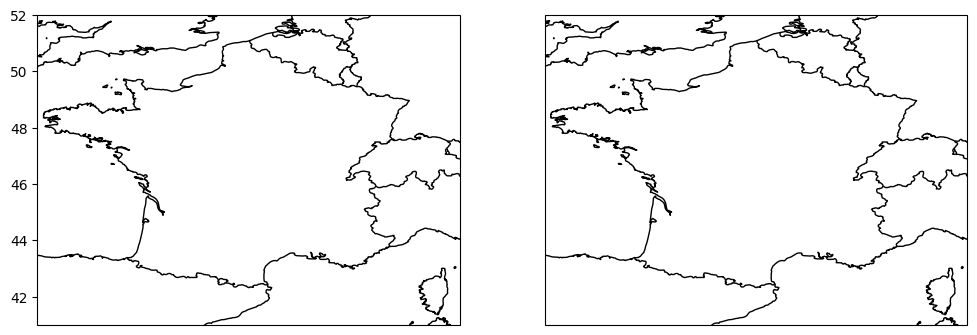

In [70]:
create_map(final_df, wgt)